# REDDIT & TWITTER TWEETS ANALYSIS

### IMPORTING THE LIBRARIES

In [1]:
import os
import re
import shutil

import kaggle
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
import spacy
from imblearn import under_sampling
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from wordcloud import WordCloud

### DOWNLOADING DATASET - https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset

In [2]:
os.makedirs("datasets/", exist_ok=True)

if "Reddit_Data.csv" or "Twitter_Data.csv" not in os.listdir("datasets/"):
    kaggle.api.dataset_download_files(
        "cosmos98/twitter-and-reddit-sentimental-analysis-dataset"
    )
    shutil.unpack_archive(
        "twitter-and-reddit-sentimental-analysis-dataset.zip", extract_dir="./datasets"
    )

In [3]:
# reading data
reddit_df = pd.read_csv("./datasets/Reddit_Data.csv")
reddit_df.rename({"clean_comment": "comment"}, inplace=True, axis="columns")

twitter_df = pd.read_csv("./datasets/Twitter_Data.csv", nrows=40000)
twitter_df.rename({"clean_text": "tweet"}, inplace=True, axis="columns")

In [4]:
reddit_df.head()

,comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [5]:
twitter_df.head()

,tweet,category
0,when modi promised “minimum government maximum...,-1
1,talk all the nonsense and continue all the dra...,0
2,what did just say vote for modi welcome bjp t...,1
3,asking his supporters prefix chowkidar their n...,1
4,answer who among these the most powerful world...,1


## EDA

### Categories
So, there are 3 different values for category. Lets encode these numeric value to categorical as folllows

* -1 to Negative,
*  0 to Neutral,
* 1 to Positive.

In [6]:
reddit_df.category.value_counts()

category
 1    15830
 0    13142
-1     8277
Name: count, dtype: int64

In [7]:
twitter_df.category.value_counts()

category
 1    17065
 0    13583
-1     9352
Name: count, dtype: int64

In [8]:
reddit_df.describe()

,category
count,37249.000000
mean,0.202771
std,0.778515
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [9]:
twitter_df.describe()

,category
count,40000.000000
mean,0.192825
std,0.789468
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [10]:
reddit_df.isna().sum()

comment     100
category      0
dtype: int64

In [11]:
twitter_df.isnull().sum()

tweet       1
category    0
dtype: int64

### Dropping Rows with NaN values

In [12]:
reddit_df.dropna(axis=0, inplace=True)
twitter_df.dropna(axis=0, inplace=True)

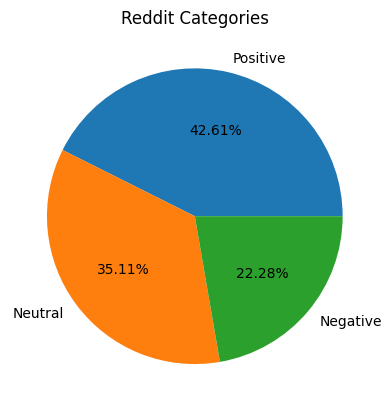

In [13]:
labels = ["Positive", "Neutral", "Negative"]

plt.title("Reddit Categories")
plt.pie(
    reddit_df.category.value_counts(),
    labels=labels,
    autopct="%.2f%%",
);

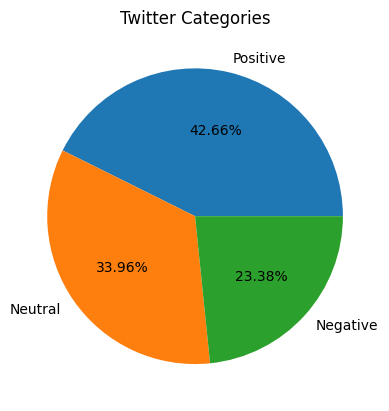

In [14]:
plt.title("Twitter Categories")
plt.pie(
    twitter_df.category.value_counts(),
    labels=labels,
    autopct="%.2f%%",
);

# NLTK and Spacy

### The usual cleaning process in NLP involves:-

* Remove missing value if any.
* Remove unwanted character like punctuations.
* Replace all the Uppercase to lowercase as machine treat them differently but we knw meaning of 'cat' and 'CAT' is same.
* Remove type of words that follow a certain pattern like link, email, or username, these words does not contribute much in analysis and can be removed from description with he help of regular expression.
* Remove all the stopwords like pronoun, articles etc. these words occur in very huge number in any sentence but does not contribute much in NLP analysis and thus can be removed.
* At last Changing the verb form to its root form. example :- root word for 'Playing' and 'Played' will be 'Play'

### Using NLTK to remove stop words from Reddit dataset

In [15]:
# nltk.download("stopwords")
STOPWORDS = stopwords.words("english")


def clean_text_nltk(text):
    text = text.lower()
    text = re.sub(r"[^0-9a-zA-Z]", " ", text)
    text = re.sub(r"\s+", " ", text)
    filtered_tokens = " ".join(word for word in text.split() if word not in STOPWORDS)
    return filtered_tokens

In [16]:
reddit_df.head()

,comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [17]:
reddit_df.loc[:, "comment"] = reddit_df.comment.apply(clean_text_nltk)
reddit_df.head()

,comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal wrappi...,0
4,benefit may want read living buddha living chr...,1


### Using Spacy to remove stop words from Twitter dataset

In [18]:
try:
    nlp = spacy.load("en_core_web_sm")
except:
    os.system("python -m spacy download en_core_web_sm")


def clean_text_spacy(text):
    text = text.lower()
    text = re.sub(r"[^0-9a-zA-Z]", " ", text)
    text = re.sub(r"\s+", " ", text)
    doc = nlp(text)
    filtered_tokens = [token.text for token in doc if not token.is_stop]
    return filtered_tokens

In [19]:
tweet_ = twitter_df.loc[:2000]
tweet_.tweet.apply(clean_text_spacy)

0       [modi, promised, minimum, government, maximum,...
1           [talk, nonsense, continue, drama, vote, modi]
2       [vote, modi, welcome, bjp, told, rahul, main, ...
3       [asking, supporters, prefix, chowkidar, names,...
4       [answer, powerful, world, leader, today, trump...
                              ...                        
1996    [modi, meetings, andhra, pradesh, march, april...
1997    [vote, difference, anil, kapoor, answers, modi...
1998            [yes, want, movie, great, narendra, modi]
1999    [documents, reveal, modi, javadekars, war, ind...
2000    [equation, simple, want, development, vote, mo...
Name: tweet, Length: 2000, dtype: object

In [20]:
twitter_df.loc[:, "tweet"] = twitter_df.tweet.apply(clean_text_nltk)
twitter_df

,tweet,category
0,modi promised minimum government maximum gover...,-1
1,talk nonsense continue drama vote modi,0
2,say vote modi welcome bjp told rahul main camp...,1
3,asking supporters prefix chowkidar names modi ...,1
4,answer among powerful world leader today trump...,1
...,...,...
39995,shameless took years understand gst proposed k...,0
39996,forget civil war anti national naxal separatis...,1
39997,legitimate arrest antony making nirav modi vij...,-1
39998,yes put jail last last 3yr work modi modi bett...,1


## Lemmatizing and Stemming

In [21]:
# nltk.download("wordnet")

nltk_stem = nltk.PorterStemmer()
nltk_lemmat = nltk.WordNetLemmatizer()

In [22]:
print(nltk_stem.stem("geese"))
print(nltk_stem.stem("goose"))

gees
goos


In [23]:
print(nltk_lemmat.lemmatize("geese"))
print(nltk_lemmat.lemmatize("goose"))

goose
goose


### Lemmatizing using Spacy

In [24]:
nlp = spacy.load("en_core_web_sm")
doc = nlp("geese")
for token in doc:
    print(token.lemma_)

doc = nlp("goose")
for token in doc:
    print(token.lemma_)

geese
goose


Since stemming reduces the words to their base forms, even if there is no meaning, it is better to use a lemmatizer.

In [25]:
def lemmat_corpus(doc):
    filtered_doc = "".join(nltk_lemmat.lemmatize(word) for word in doc)
    return filtered_doc

In [26]:
reddit_df.loc[:, "comment"] = reddit_df.comment.apply(lemmat_corpus)
reddit_df.comment

0        family mormon never tried explain still stare ...
1        buddhism much lot compatible christianity espe...
2        seriously say thing first get complex explain ...
3        learned want teach different focus goal wrappi...
4        benefit may want read living buddha living chr...
                               ...                        
37244                                                jesus
37245    kya bhai pure saal chutiya banaya modi aur jab...
37246                 downvote karna tha par upvote hogaya
37247                                            haha nice
37248                            facebook working bjp cell
Name: comment, Length: 37149, dtype: object

In [27]:
twitter_df.loc[:, "tweet"] = twitter_df.tweet.apply(lemmat_corpus)
twitter_df.tweet

0        modi promised minimum government maximum gover...
1                   talk nonsense continue drama vote modi
2        say vote modi welcome bjp told rahul main camp...
3        asking supporters prefix chowkidar names modi ...
4        answer among powerful world leader today trump...
                               ...                        
39995    shameless took years understand gst proposed k...
39996    forget civil war anti national naxal separatis...
39997    legitimate arrest antony making nirav modi vij...
39998    yes put jail last last 3yr work modi modi bett...
39999    enquiring health senior citizen way village ju...
Name: tweet, Length: 39999, dtype: object

### Word Cloud for Reddit Dataset

In [28]:
map = {1: "Positive", 0: "Neutral", -1: "Negative"}


def printWordCloud(x, cat):
    cat_tweet = " ".join([word for word in x[x["category"] == cat]["comment"]])

    wc = WordCloud(background_color="white", max_words=50, stopwords=STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(16, 10))
    plt.imshow(wc.generate(cat_tweet))
    plt.title("{} Sentiment Words".format(map[cat]), fontsize=20)
    plt.axis("off")
    plt.show()

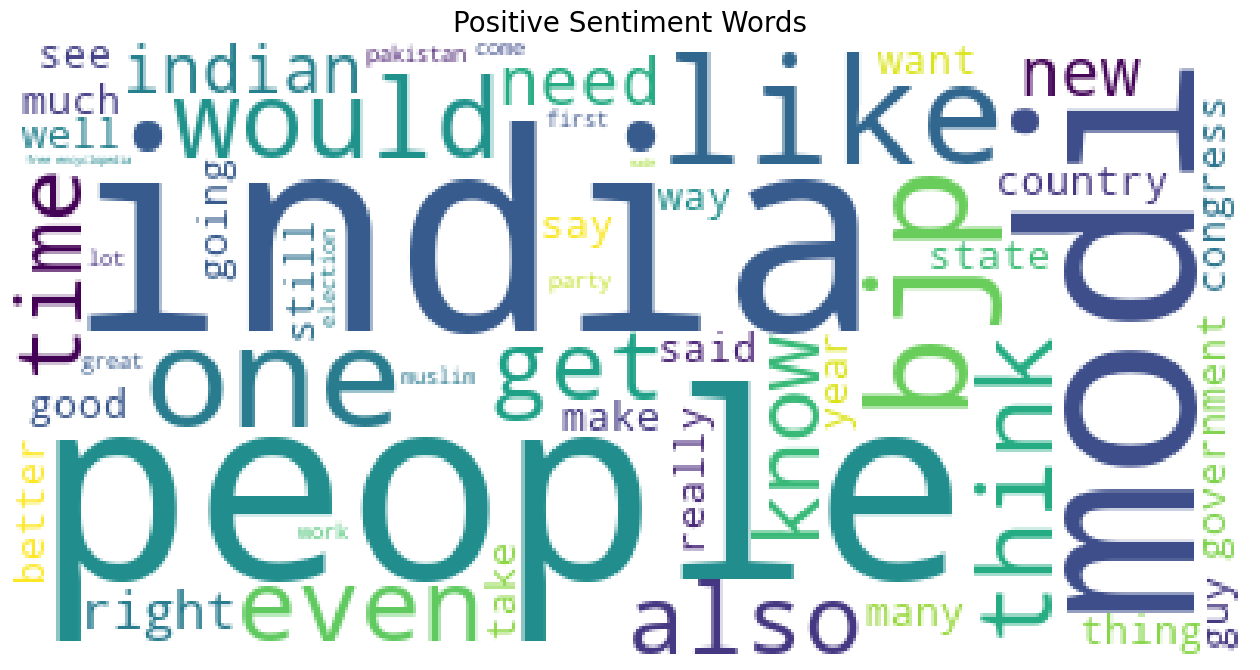

In [29]:
printWordCloud(reddit_df, 1)

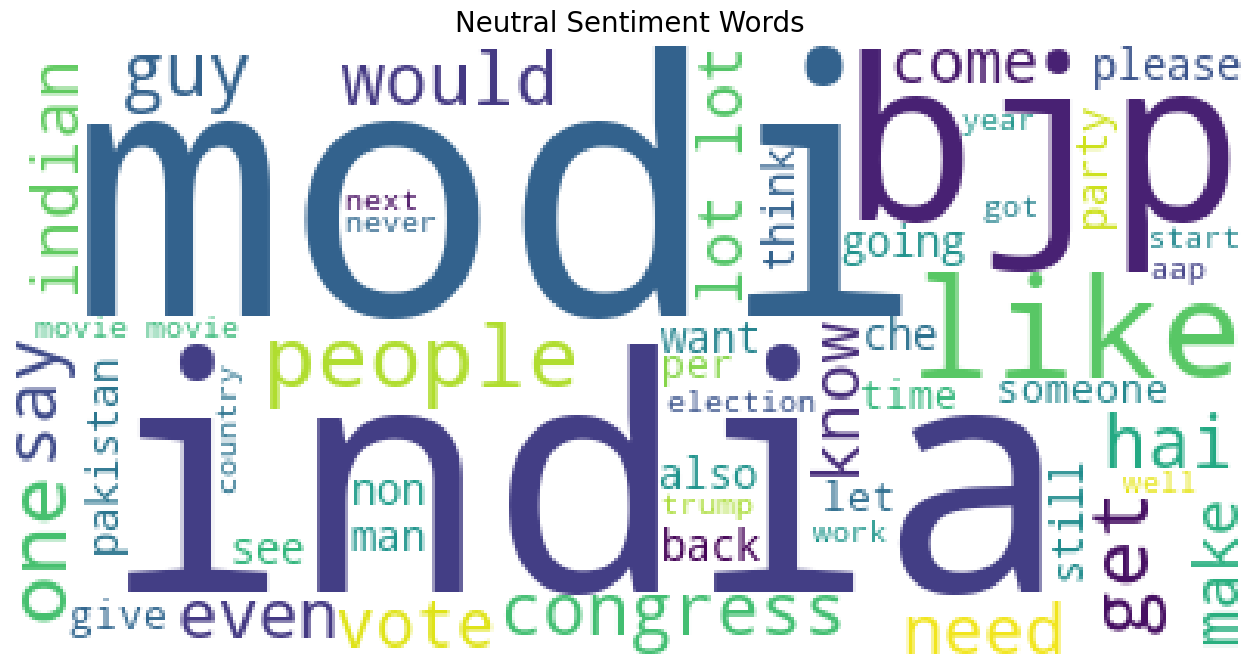

In [30]:
printWordCloud(reddit_df, 0)

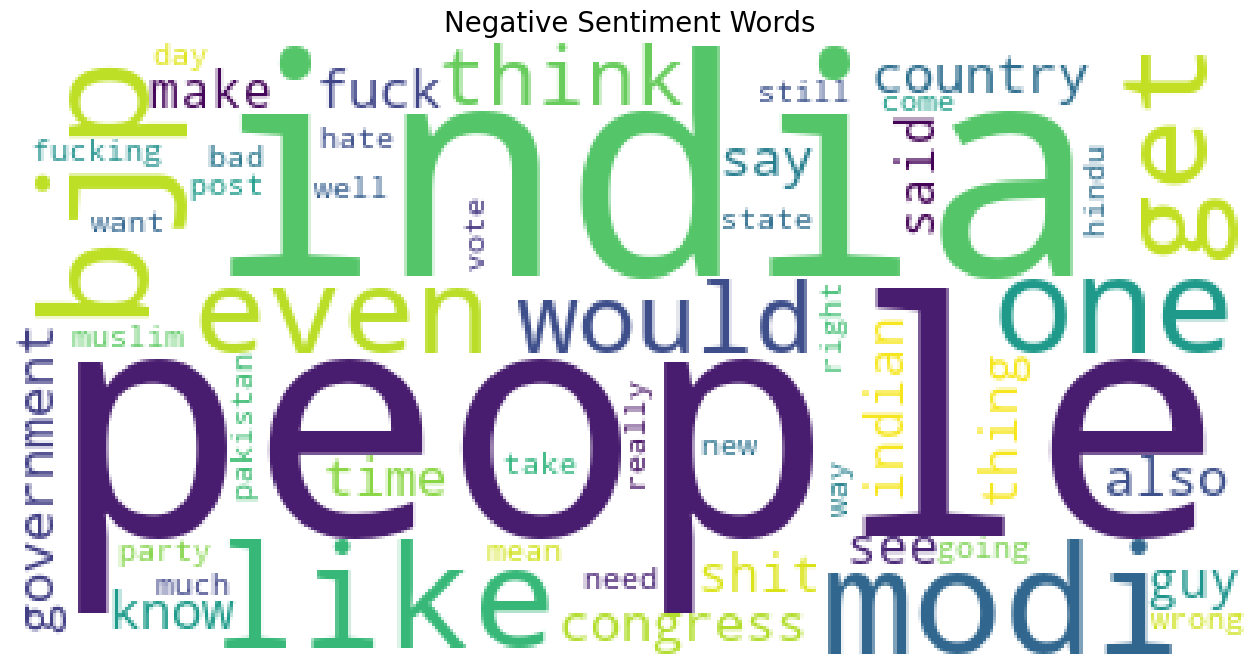

In [31]:
printWordCloud(reddit_df, -1)

### Word Cloud for Twitter Dataset

In [32]:
map = {1: "Positive", 0: "Neutral", -1: "Negative"}


def printWordCloud(x, cat):
    cat_tweet = " ".join([word for word in x[x["category"] == cat]["tweet"]])

    wc = WordCloud(background_color="white", max_words=50, stopwords=STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(16, 10))
    plt.imshow(wc.generate(cat_tweet))
    plt.title("{} Sentiment Words".format(map[cat]), fontsize=20)
    plt.axis("off")
    plt.show()

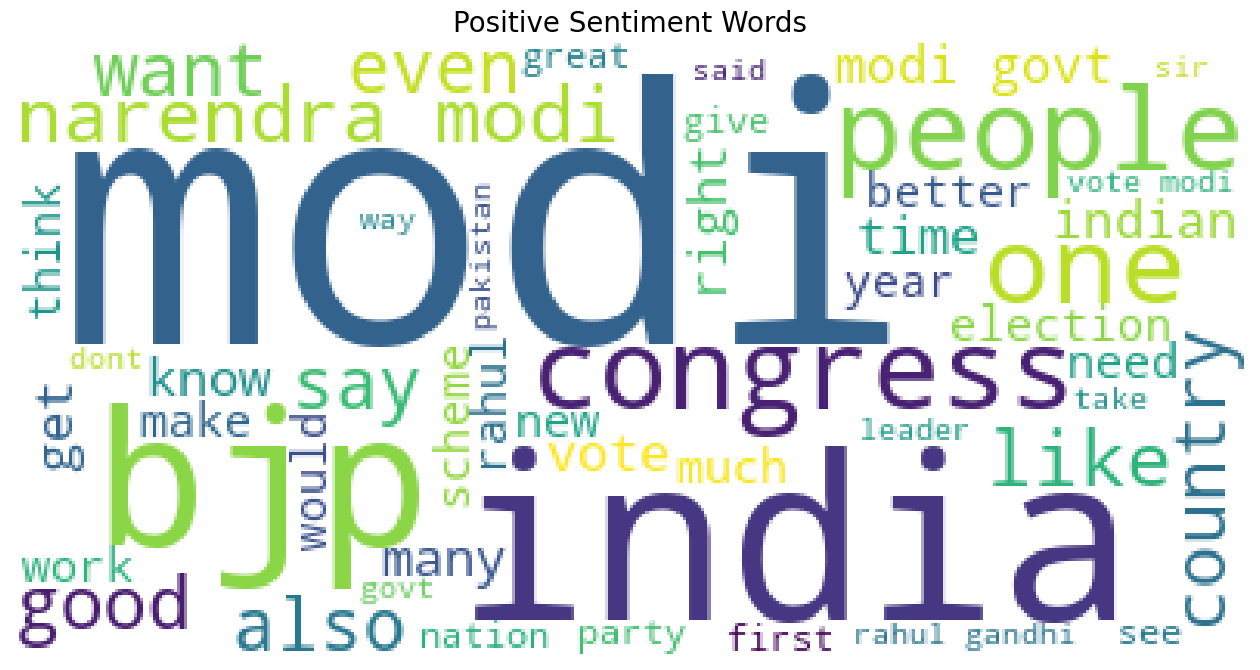

In [33]:
printWordCloud(twitter_df, 1)

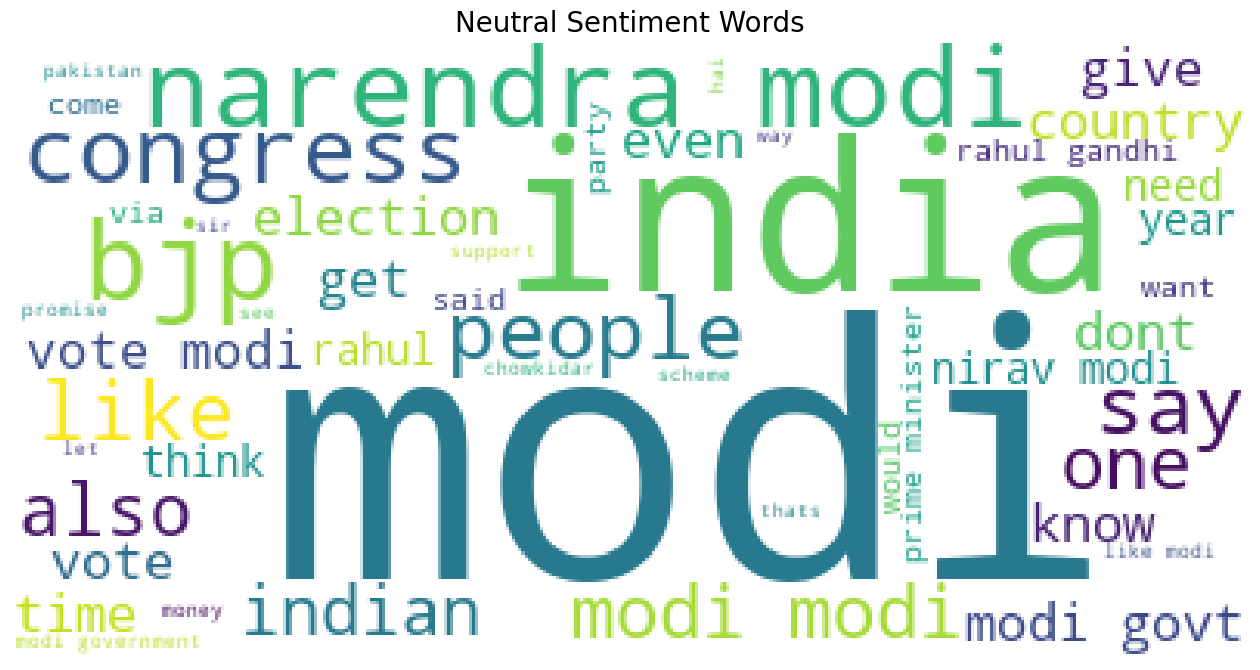

In [34]:
printWordCloud(twitter_df, 0)

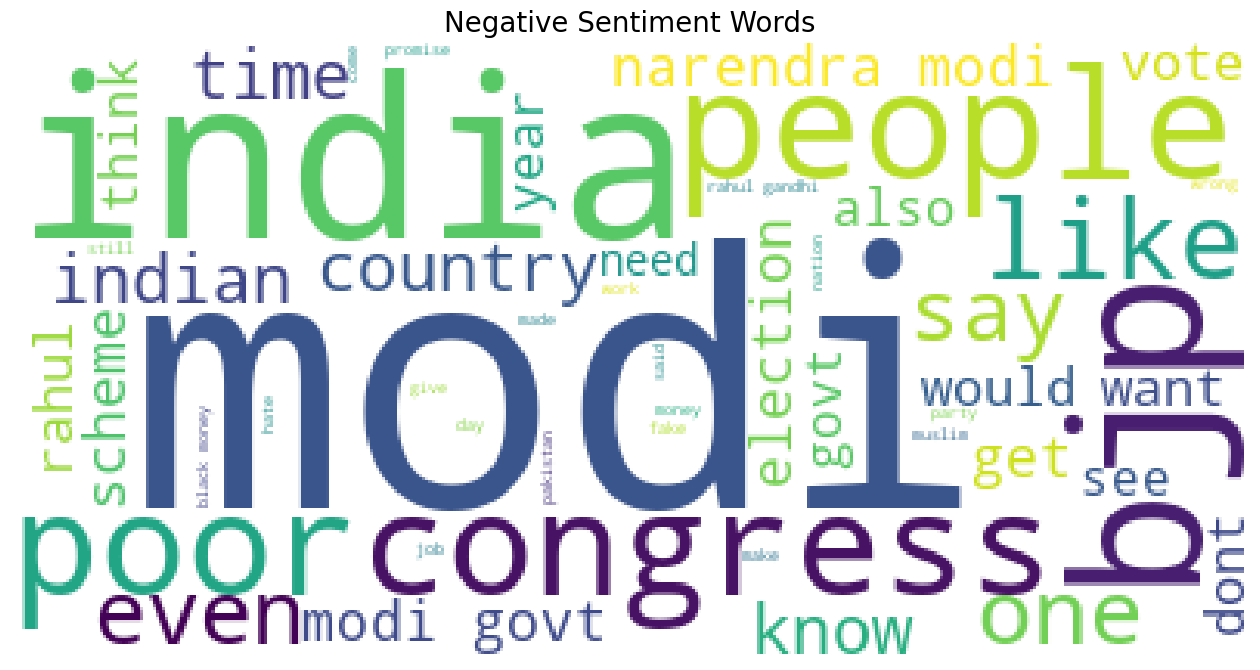

In [35]:
printWordCloud(twitter_df, -1)

## Building Model for Reddit Dataset

In [36]:
reddit_df.iloc[:10000].category.value_counts()

category
 1    4446
 0    3272
-1    2282
Name: count, dtype: int64

In [37]:
undersample = under_sampling.RandomUnderSampler()

X, y = undersample.fit_resample(reddit_df.iloc[:10000, :-1], reddit_df.iloc[:10000, -1])

In [38]:
X = pd.DataFrame(X)
X.head()

,comment
2,seriously say thing first get complex explain ...
5,sit together watch simpsons episode lisa becom...
8,two varieties christians dogmatic dwell words ...
15,evil include lady pai chunked
17,technically could argue sobek evil would repre...


In [39]:
y.value_counts()

category
-1    2282
 0    2282
 1    2282
Name: count, dtype: int64

###  TfidfVectorizer

In [40]:
X_ = "\n".join(X["comment"]).split("\n")

tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(X_)
tranformed_X = tfidf_matrix.toarray()
tranformed_X.shape

(6846, 22333)

In [41]:
y.shape

(6846,)

### TRAINING AND TESTING DATA

In [42]:
x_train, x_test, y_train, y_test = train_test_split(
    tranformed_X, y, random_state=24, test_size=0.2, stratify=y
)

### Building ML Model

**Naive Bayes**

In [43]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)

print(
    "Classification Report is:\n",
    classification_report(y_test, y_pred, zero_division=False),
)
print("Training Score:\n", gnb.score(x_train, y_train) * 100)
print("Testing Score:\n", gnb.score(x_test, y_test) * 100)

Classification Report is:
               precision    recall  f1-score   support

          -1       0.44      0.55      0.49       456
           0       0.78      0.51      0.62       457
           1       0.44      0.48      0.46       457

    accuracy                           0.51      1370
   macro avg       0.55      0.51      0.52      1370
weighted avg       0.55      0.51      0.52      1370

Training Score:
 94.41197954711468
Testing Score:
 51.386861313868614


### KNN

In [44]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)

print(
    "Classification Report is:\n",
    classification_report(y_test, y_pred, zero_division=False),
)
print("Training Score:\n", knn.score(x_train, y_train) * 100)
print("Testing Score:\n", knn.score(x_test, y_test) * 100)

Classification Report is:
               precision    recall  f1-score   support

          -1       0.80      0.02      0.03       456
           0       0.34      1.00      0.50       457
           1       1.00      0.01      0.03       457

    accuracy                           0.34      1370
   macro avg       0.71      0.34      0.19      1370
weighted avg       0.71      0.34      0.19      1370

Training Score:
 34.18553688823959
Testing Score:
 34.23357664233577


### RandomForestClassifier

In [45]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

print(
    "Classification Report is:\n",
    classification_report(y_test, y_pred, zero_division=False),
)
print("Training Score:\n", rfc.score(x_train, y_train) * 100)
print("Testing Score:\n", rfc.score(x_test, y_test) * 100)

Classification Report is:
               precision    recall  f1-score   support

          -1       0.78      0.57      0.66       456
           0       0.73      0.96      0.83       457
           1       0.76      0.73      0.75       457

    accuracy                           0.76      1370
   macro avg       0.76      0.76      0.75      1370
weighted avg       0.76      0.76      0.75      1370

Training Score:
 99.981738495252
Testing Score:
 75.54744525547446


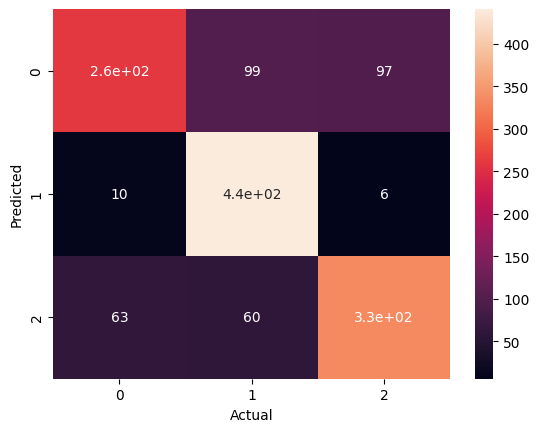

In [46]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.xlabel("Actual")
plt.ylabel("Predicted");